## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [Resources](#resources)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [53]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [54]:
df = pd.read_csv('ab_data.csv', parse_dates=['timestamp'])
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [55]:
df.shape[0]
# There are 294478 rows.

294478

c. The number of unique users in the dataset.

In [56]:
df['user_id'].nunique()
# There are 290584 unique users identified by a user_id.

290584

d. The proportion of users converted.

In [57]:
df['converted'].mean()
# Overall 11.97% of the users converted.

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [58]:
df.groupby(by=['landing_page', 'group']).count()
# They don't line up for the combination new_page and control
# and the combination old_page and treatment:
# new_page and control = 1928, plus
# old_page and treatment = 1965, 
# so in total 3893.

user_id  timestamp  converted
landing_page group                                   
new_page     control       1928       1928       1928
             treatment   145311     145311     145311
old_page     control     145274     145274     145274
             treatment     1965       1965       1965

f. Do any of the rows have missing values?

In [59]:
print(df.info())
pd.isna(df).sum()
# There is no missing data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null datetime64[ns]
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB
None


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [60]:
# Only select rows where landing page and group align correctly.
# Although both columns are retained, they contain the same information. 
df2 = df.query('(landing_page == "new_page" & group == "treatment") | \
                (landing_page == "old_page" & group == "control")')
               
df2.groupby(by=['landing_page', 'group']).count()

,,user_id,timestamp,converted
landing_page,group,,,
new_page,treatment,145311,145311,145311
old_page,control,145274,145274,145274


In [61]:
# Double Check all of the correct rows were removed - this should be 0.
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [62]:
df2['user_id'].nunique()
# There are 290584 unique users identified by a user_id.

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [63]:
# The resulting object from value_counts() is sorted in descending order 
# so that the first element is the most frequently-occurring element. 
df2['user_id'].value_counts().head()
# The repeated user_id is 773192.

773192    2
630732    1
811737    1
797392    1
795345    1
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [64]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [65]:
df2 = df2.drop_duplicates(subset='user_id', keep='first')
df2[df2['user_id'] == 773192]
# Using inplace raises a warning, so used assignment here instead.

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [66]:
df2['converted'].mean()
# Probability of an individual in any group converting is 11.96%.

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [67]:
cr_control = df2[df2['group'] == 'control']['converted'].mean()
cr_control
# Probability of an individual in the control group converting is 12.04%.

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [68]:
cr_treatment = df2[df2['group'] == 'treatment']['converted'].mean()
cr_treatment
# Probability of an individual in the treatment group converting is 11.88%.

0.11880806551510564

d. What is the probability that an individual received the new page?

In [69]:
(df2['landing_page'] == 'new_page').mean()
# Probability of an individual receiving the new page is 50.01%.

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

From examinining the results obtained, there is **not** sufficient evidence that the new treatment page leads to more conversions. The conversion rate for the treatment group is 11.88%, compared to a rate of 12.04% for the control group. The rate for the treatment group would first need to be greater than that of the control group in order to even begin consideration whether the evidence is strong enough (for example, whether the increase has statistical and practical significance) to say that the new page leads to more conversions, and that is not the case.  

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

An important consideration in defining the Null Hypothesis is which of the two types of error (Type I and Type II) lead to the worst outcome. The Null Hypothesis should be selected such that the worst outcome corresponds to a Type I error. First, the worst outcome must be identified. It is specified that *"the old page is better unless the new page proves to be definitely better"*, from which the conclusion may be drawn that the effort to implement the new page will not pay off without definitive improvement in the conversion rate. So the worst case in the absence of any other information is to decide that the new page is better when it actually is not. A Type I error occurs when the decision is for the Alternative Hypothesis when the Null Hypothesis is true (false positive). So the selected Null Hypothesis is that the new page is not definitively (i.e. significantly) better than the old page. That means, it could be worse than or the same as the old page. 

The following analysis is therefore based on the following hypotheses:

**Null Hypothesis**: 
**$p_{new}$** <=  **$p_{old}$**

The conversion rate of the new page is not significantly greater than that of the old page. 

**Alternative Hypothesis**: 
**$p_{new}$** >  **$p_{old}$**

The conversion rate of the new page is significantly greater than that of the old page. 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [70]:
cr_under_null = df2['converted'].mean()    # Under the null, use both groups.
cr_under_null
# The convert rate for p-new under the null is: 11.96%.

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [71]:
cr_under_null = df2['converted'].mean()    # Same as above: under the null, use both groups.
cr_under_null
# The convert rate for p-old under the null is: 11.96%.

0.11959708724499628

c. What is $n_{new}$?

In [72]:
# Index 0 is the treatment i.e. new, 1 is the control i.e. old
n_new = df2['group'].value_counts()[0]
n_new
# The sample size n-new is: 145310.

145310

d. What is $n_{old}$?

In [73]:
#index 0 is treatment i.e. new, 1 is control i.e. old
n_old = df2['group'].value_counts()[1]
n_old
# The sample size n-old is: 145274.

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [74]:
# Samples are drawn from a binomial distribution with specified parameters using
# np.random.binomial(n, p, size=None) for n trials and p probability of success.
# n is set to the number of dependent transactions, which is here 1 (a page visit).
# p is set to the conversion rate under the null, i.e. same for old and new.
# Size is the output shape - set to new sample size to collect array of 1's and 0's.
new_page_converted = np.random.binomial(1, cr_under_null, size=n_new)
print(len(new_page_converted))
new_page_converted

145310


array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [75]:
# Size is the output shape - set to old sample size to collect array of 1's and 0's.
old_page_converted = np.random.binomial(1, cr_under_null, size=n_old)
print(len(old_page_converted))
old_page_converted

145274


array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [76]:
new_page_converted.mean() - old_page_converted.mean()

0.000603556317951115

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [77]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, cr_under_null, size=n_new)
    old_page_converted = np.random.binomial(1, cr_under_null, size=n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
# Convert to numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

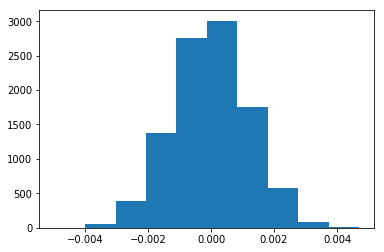

In [78]:
plt.hist(p_diffs);

Binomial distributions were generated according the the probability of a conversion under the null (i.e. in the case where there is no influence of the new page compared to the old page). The probability of a conversion under the null was calculated from the mean of the 1s and 0s, disregarding whether they were from the old page or the new page. The binomial distribution was generated for the new page sample size or the old page sample size accordingly. From each of these distributions the mean of the 1s and 0s was calculated. The distribution of the means for the new page and for the old page are their sampling distributions. 

Now in this case the hypotheses can be rewritten as:

**Null Hypothesis**: 
**$p_{new}$** - **$p_{old}$** <= 0

The difference in conversion rate of the new page with respect to the old page is less than or equal to zero. This corresponds to the part of the distribution at and to the left of zero.

**Alternative Hypothesis**: 
**$p_{new}$** - **$p_{old}$** > 0

The difference in conversion rate of the new page with respect to the old page is greater than zero. This corresponds to the part of the distribution to the right of zero. 

The difference is calculated by subtracting the means of the old page from the means of the new page, giving the *p_diffs* distribution. The area of interest is the right side of the distribution, where the differences are greater than zero. The most likely differences are around zero. The further away from zero, the less probable are the differences.

These differences were calculated under the null. If a large difference were to be calculated that was far to the right of this distribution, it could be considered very unlikely under the null and so evidence for the alternative hypothesis. It is necessary to decide how unlikely such a difference needs to be before it is accepted as sufficient evidence. 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

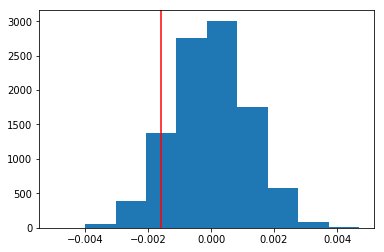

In [79]:
# treatment converted = 17264 / 145310 = 0.11880806551510564
# control converted = 17489 / 145274 = 0.1203863045004612
# total = 145310 + 145274 = 290584
# difference = 0.11880806551510564 - 0.1203863045004612 = -0.0015782389853555567
obs_diff = cr_treatment - cr_control
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red');

In [80]:
(p_diffs > obs_diff).mean()

0.9045

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Ca. 90-91% of the simulated differences under the assumption that the Null Hypothesis is true (aka "under the null") are greater than the observed difference between the control and the treatment group. The value will vary slightly on each execution due to small random variations when using np.random.binomial. This calculation is called the "p-value". The p-value is the probability of observing a value - or one more extreme in favor of the Alternative Hypothesis - if the Null Hypothesis is true. The distribution of differences (p-diffs) was generated under the assumption that the Null Hypothesis is true. A value in favor of the Alternative Hypothesis would be observed to the right of zero (because it was defined as **$p_{new}$** - **$p_{old}$** > 0). So the p-value will be the cumulative probability of all differences in the distribution to the right of (greater than) the observed difference, which is ca. 90-91%.

The specification defines that the new page must prove to be definitely better at a Type I error rate of 5%. If the observed difference were such that the cumulative probability of all differences in the distribution to the right of (greater than) the observed difference were less than or equal to 5%, then the probability of making a Type I error (deciding that the Alternative Hypothesis is true when in fact the Null Hypothesis is true) would be less than or equal to 5%. An observed difference under this value might still be possible under the Null Hypothesis but it is unlikely enough to decide to reject it, given the amount of risk of making an error that has been accepted (5%).

The observed difference leading to a p-value of ca. 90-91% is clearly far away from the 5% needed to reject the Null Hypothesis. There is therefore insufficient evidence to reject the null hypothesis and the conclusion is that the new page is not achieving a significantly better conversion rate than the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [81]:
import statsmodels.api as sm

convert_old = df2[df2['landing_page'] == 'old_page']['converted'].sum()
convert_new = df2[df2['landing_page'] == 'new_page']['converted'].sum()
n_old = df2['group'].value_counts()[1]
n_new = df2['group'].value_counts()[0]
count_converts = [convert_new, convert_old]
nobs_trials = [ n_new, n_old]
count_converts, nobs_trials

([17264, 17489], [145310, 145274])

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [82]:
# proportions_ztest(count, nobs, 
#        value=None, alternative='two-sided', prop_var=False)
# alternative: In the two sample test, larger means p1 > p2 where 
# p1 is the proportion of the first sample (new_page) and p2 of the second one (old_page).
# prop_var: If prop_var is false, then the variance of the proportion estimate is calculated 
# based on the sample proportion. Alternatively, a proportion can be specified to calculate 
# this variance. Common use case is to use the proportion under the Null hypothesis 
# (cr_under_null) to specify the variance of the proportion estimate.
z_score, p_value = sm.stats.proportions_ztest(count_converts, nobs_trials, 
        alternative='larger', prop_var = cr_under_null)
z_score, p_value
# (-1.3109241984234394, 0.18988337448195103)

(-1.3109241984234394, 0.9050583127590245)

In [83]:
from scipy.stats import norm
# The p-value is the cumulative probability to the right of the z_score.
# This can be confirmed with a cumulative distribution function (cdf)
# which calculates the cumulative probability up until the z-score.
# The remaining probability is subtracted from 1 since the total area 
# under the normal curve is 1. 
z_significance = 1 - norm.cdf(z_score)
# The critical value corresponding to 5% Type I error can be calculated using
# the inverse of the cdf, the percent point function (ppf).
critical_value = norm.ppf(1-(0.05))
critical_value, z_significance

(1.6448536269514722, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

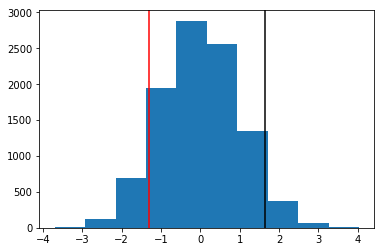

In [84]:
# Generate random variates of a normal distribution
random_normal = norm.rvs(size=10000)

plt.hist(random_normal);
plt.axvline(x=z_score, color='red');
plt.axvline(x=critical_value, color='black');

The z-score is -1.31 (red line) which does not exceed the critical value (black line) corresponding to 5% Type I error, which is 1.64. Therefore there is insufficient evidence to reject the null hypothesis. The difference between the two proportions, i.e. the conversion rates of the old and new pages, is not significantly greater than 0. 

9.51% of the area of the z distribution is above the z-score which agrees approximately with the previous findings. The reason for any small difference is that the previous was calculated from the bootstrapped simulation, which will have small random variations. To prove this, the bootstrap was run 5 times and gave the following results: 90.47%, 90.94%, 90.57%, 90,63%, 90.08%.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be achieved by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [85]:
df3 = df2.copy() # Take a copy for the new regression approach. 
df3.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [86]:
# Change categorical landing_page to dummy variables and drop the old page.
# The ab_page column, is 1 when an individual receives the treatment and 0 if control.
df3[['ab_page', 'not_ab_page']] = pd.get_dummies(df3['landing_page'])
df3 = df3.drop('not_ab_page', axis=1)
# Add an intercept column.
df3['intercept'] = 1

In [87]:
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [88]:
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [89]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        09:28:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is: 0.190.

The null and alterative hypotheses in Part II were:

**Null Hypothesis**: 
**$p_{conversion-rate-new}$** <= **$p_{conversion-rate-old}$**

The conversion rate with the new page is not significantly greater than that with the old page. 

**Alternative Hypothesis**: 
**$p_{conversion-rate-new}$** > **$p_{conversion-rate-old}$**

The conversion rate with the new page is significantly greater than that with the old page. 


The null and alterative hypotheses in the logistic regression are:

**Null Hypothesis**: 
**$p_{conversion-odds-new}$** <= **$p_{conversion-odds-old}$**

The odds of a conversion is not significantly greater with the new page that with the old page. 

**Alternative Hypothesis**: 
**$p_{conversion-odds-new}$** > **$p_{conversion-odds-old}$**

The odds of a conversion is significantly greater with the new page that with the old page. 

The p-value from Part II is used to assess statistical significance of the difference between two proportions: the conversion rate with new and old page. 
The p-value in the logistic regression is used to assess statistical significance of the change in the odds of conversion with the new page instead of the old page, which is the baseline. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The group category maps exactly the the landing page category so there is no additional information for the model. The user id has no meaning in the context of the tests (although could be checked for some kind of bias, e.g. if the user profile changed as more users were added). Timestamps are not helpful as they are unique values for each data point. However, it could be possible to discretize the timestamps, e.g. to distinguish periods of the day of of the week, to see if such periods have a significant impact on the results. Combining the data with profile data about the users (e.g. in which country they reside) could provide new insights. 

In general, adding other factors may help identify conditions that are more conducive to a higher conversion rate, leading to a better understanding of the results and perhaps ideas for improving the conversion rate of the new page. Adding new factors indiscriminately may improve the fit of the model, but there is a danger of overfitting, i.e. the resulting model is optimized for the particular set of data and would perform less well with other data. If additional factors introduce issues such as multicollinearity or outliers (which may have excessive leverage on the model), they may further reduce the effectiveness of the model. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [90]:
import pandas as pd
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [91]:
# Create the necessary dummy variables.
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
# Select as baseline the country with the most data points: the US.
df_new = df_new.drop('US', axis=1)
# Add an intercept column.
df_new['intercept'] = 1

In [92]:
df_new.head()

,country,timestamp,group,landing_page,converted,CA,UK,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1


In [93]:
# Fit Your Linear Model And Obtain the Results.
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA','UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        09:28:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

Neither the p-value for Canada (0.129) nor for the UK (0.456) show a significant influence of the country on the result compared to the baseline (US). By removing the UK it is possible to examine the significance of Canada compared to a baseline of "not-Canada".

In [94]:
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:               1.259e-05
Time:                        09:28:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1016
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9941      0.006   -340.272      0.000      -2.006      -1.983
CA            -0.0434      0.027     -1.629      0.103      -0.096       0.009
==============================================================================
"""

The p-value is slightly better (changed from 0.129 to 0.103) but is still insufficient to reject the Null Hypothesis. Therefore country does not have a significant impact on conversion. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [95]:
df_new['country_page_interact'] = df_new['country'] + '_' + df_new['landing_page']
print(df_new['country_page_interact'].value_counts())
df_new[['CA_new_page', 'CA_old_page', 'UK_new_page', 'UK_old_page', 'US_new_page', 'US_old_page']] = pd.get_dummies(df_new['country_page_interact'])
# Select as baseline the country with the most data points: the US.
df_new = df_new.drop('US_new_page', axis=1)
# Fit Your Linear Model And Obtain the Results.

US_new_page    101903
US_old_page    101716
UK_old_page     36360
UK_new_page     36106
CA_new_page      7301
CA_old_page      7198
Name: country_page_interact, dtype: int64


In [96]:
df_new.head()

,country,timestamp,group,landing_page,converted,CA,UK,intercept,country_page_interact,CA_new_page,CA_old_page,UK_new_page,UK_old_page,US_old_page
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,UK_old_page,0,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1,US_new_page,0,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,UK_new_page,0,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,UK_old_page,0,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,UK_new_page,0,0,1,0,0


In [97]:
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA_new_page', 'CA_old_page', 'UK_new_page', 'UK_old_page', 'US_old_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:               3.482e-05
Time:                        09:28:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0070      0.010   -207.045      0.000      -2.026      -1.988
CA_new_page    -0.0644      0.038     -1.679      0.093      -0.140       0.011
CA_old_page     0.0030      0.038      0.081      0.936      -0.071       0.077
UK_new_page     0.0257      0.019      1.363      0.173      -0.011       0.063
UK_old_page     0.0148      0.019      0.787      0.431      -0.022       0.052
US_old_page     0.0206      0.014      1.505      0.132      -0.006       0.047
===============================================================================
"""

In [98]:
# The results object contains the odds ratios.
print('The odds ratios are:')
print(np.exp(results.params))
# odds ratios and 95% CI
params = results.params
conf = results.conf_int()
conf['odds_ratio'] = params
conf.columns = ['2.5%', '97.5%', 'odds_ratio']
print('The 95% confidence intervals for the odds ratios are:')
np.exp(conf)

The odds ratios are:
intercept      0.134386
CA_new_page    0.937618
CA_old_page    1.003040
UK_new_page    1.025986
UK_old_page    1.014930
US_old_page    1.020776
dtype: float64
The 95% confidence intervals for the odds ratios are:


,2.5%,97.5%,odds_ratio
intercept,0.131857,0.136963,0.134386
CA_new_page,0.869694,1.010848,0.937618
CA_old_page,0.931599,1.079960,1.003040
UK_new_page,0.988837,1.064530,1.025986
UK_old_page,0.978166,1.053076,1.014930
US_old_page,0.993806,1.048479,1.020776


In [99]:
# The factors other than CA_new_page are removed, max. p-value first.
# 1. Removed CA_old_page (p = 0.936)
# 2. Removed UK_old_page (new p = 0.433)
# 3. Removed UK_new_page (new p = 0.227)
# 4. Removed US_old_page (new p = 0.306)
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA_new_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:               2.016e-05
Time:                        09:28:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.03834
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9944      0.006   -344.689      0.000      -2.006      -1.983
CA_new_page    -0.0771      0.038     -2.052      0.040      -0.151      -0.003
===============================================================================
"""

In [100]:
# odds ratio - 1 unit increase affects odds of conversion
print(np.exp(results.params))
# odds ratios and 95% CI
params = results.params
conf = results.conf_int()
conf['odds_ratio'] = params
conf.columns = ['2.5%', '97.5%', 'odds_ratio']
# Decrease in odds of conversion with the combinations compared to baseline
1/np.exp(conf)

intercept      0.136099
CA_new_page    0.925811
dtype: float64


,2.5%,97.5%,odds_ratio
intercept,7.431364,7.264713,7.347566
CA_new_page,1.162677,1.003450,1.080134


None of the country-page combinations showed a significant difference in odds ratio compared to the baseline, which was the combination US and new_page. By reducing the model step by step, each time removing the highest p-value combination, one combination remained that was statistically significant: Canada and new_page. It was slightly less likely that this combination would lead to a conversion than the US and new_page combination, all other variables being held constant. So a user in Canada might be less convinced by the new page to convert than a user in the US, but the decrease in odds of conversion is only 1.08, so having no practical significance. 

<a id='conclusions'></a>
## Conclusions

The results of an A/B test run by an e-commerce website have been analysed to help the company decide whether they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

Test results where the new_page and treatment don't line up were removed prior to the analysis, as was one entry for a user with two entries but with identical results. It is recommended to examine the testing process to identify the root cause of mismatched entries and to ensure that the remaining data have not been compromised. 

Using different approaches, statistical tests were made to determine whether the new page leads to a higher conversion rate. The country of the user was also checked for possible influence on the conversion rate in general, and the difference in conversion rate for the old and new pages. There was insufficient evidence to support the conclusion that the new page in general or the new page from a specific country leads to a higher conversion rate, under the requirements that the risk of a Type I error be no more than 5%. 

**The conclusion is therefore that the new page will not lead to an improved conversion rate.** 

The sample size of the A/B test is sufficiently high to detect statistically small differences in conversion rate. The differences that can be detected are smaller than those which would likely have practical significance. There is therefore no reason to run the experiment longer. 

There was an interesting observation that the new page led to slightly lower odds of conversion for a user from Canada compared to the other countries (US and UK) in general. In addition  to this influence being marginally non-significant, the amount of influence on the odds of conversion (a factor of 1.08 times lower) has little practical significance. However, it may be interesting to examine the new page in light of this finding to see if any explanation may be found.

Due to time contraints the influence of times of day or times of the week (e.g. weekday vs. weekend) on the conversion rates and odds of conversion were not investigated. If this is important from a business perspective these could be checked if the project deadline were to be extended.

Although not exhaustively checked as hypotheses, there is no evidence that the new page is significantly worse than the old page. If considerable work has been invested in the new page and there are other factors in favor of its implementation, there is no reason why it should not be activated, as long as there are no expectations of improved conversion rate. If this decision is taken, a quick check of these hypotheses could easily be made.  

<a id='resources'></a>
# Resources #
In addition to links in the body of the notebook, the following were referred to: 
1. Ways of using the *result* object: 
http://blog.yhat.com/posts/logistic-regression-python-rodeo.html
2. Functions using the normal probability density function: 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html